In [1]:
from bs4 import BeautifulSoup
import urllib2
import pandas as pd
import numpy as np

from pandas_datareader import data, wb

from datetime import date, timedelta, datetime
from time import sleep
import os.path
import glob
import re
import random

import matplotlib.pyplot as plt
%matplotlib inline

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sentimenter import data as sn_data

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNetCV
# from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, silhouette_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

import pydot
from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/home/ali/Anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ali/Anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
companies = sn_data.get_companies()

In [4]:
companies['Ticker_symbol'] = companies['Ticker_symbol'].apply(lambda x: x.replace('.N', ''))

In [5]:
companies.head()

,Ticker_symbol,Security,SEC_filings,GICS_Sector,GICS_Sub_Industry,Address_of_Headquarters,Date_first_added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [6]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 0 to 504
Data columns (total 8 columns):
Ticker_symbol              505 non-null object
Security                   505 non-null object
SEC_filings                505 non-null object
GICS_Sector                505 non-null object
GICS_Sub_Industry          505 non-null object
Address_of_Headquarters    505 non-null object
Date_first_added           305 non-null object
CIK                        505 non-null int64
dtypes: int64(1), object(7)
memory usage: 35.5+ KB


## Work on this for multiprocessing

In [7]:
# import multiprocessing as mp

# filename = "datasets/articles.csv"
# chunksize = 100 # processing 100 rows at a time


# def process_frame(df):
#     # process data frame
#     sid = SentimentIntensityAnalyzer()
#     lambda_sentimenter = lambda x: pd.Series(
#         [sid.polarity_scores(x['Article'])['compound'],
#          sid.polarity_scores(x['Article'])['neg'],
#          sid.polarity_scores(x['Article'])['neu'],
#          sid.polarity_scores(x['Article'])['pos']
#         ])
#     return len(df)

# def get_sentimentaized_articles(companies):
#     reader = pd.read_table(filename, chunksize=chunksize)
#     pool = mp.Pool(6) # use 4 processes

#     funclist = []
    
#     for df in reader:
#             # process each data frame
#             f = pool.apply_async(process_frame,[df])
#             funclist.append(f)

#     result = 0
#     for f in funclist:
#             result += f.get(timeout=10) # timeout in 10 seconds

#     print "There are %d rows of data"%(result)


In [8]:
# filenames = sorted(glob.glob('datasets/sentimentalized/articles_part*.csv'))
# s_articles = [pd.read_csv(filename, encoding='utf8', index_col=0) for filename in filenames]
# s_articles = pd.concat(s_articles, axis=0)
# s_articles

In [9]:
# print len(filenames)
# filenames

In [10]:
def update_sentimentalized_articles(articles):
    filenames = sorted(glob.glob('datasets/sentimentalized/articles_part*.csv'))
    s_articles = [pd.read_csv(filename, encoding='utf8', index_col=0) for filename in filenames]
    s_articles = pd.concat(s_articles, axis=0)
    print articles.shape, s_articles.shape
    not_s_syms = [x for x in list(articles.Symbol.unique()) if x not in list(s_articles.Symbol.unique())]
    print "need to sentimentalize {} symbols".format(len(not_s_syms))
    
    if len(not_s_syms) > 0:
        not_s_articles = articles[articles['Symbol'].isin(not_s_syms)]
        sid = SentimentIntensityAnalyzer()
        lambda_sentimenter = lambda x: pd.Series(
            [sid.polarity_scores(x['Article'])['compound'],
             sid.polarity_scores(x['Article'])['neg'],
             sid.polarity_scores(x['Article'])['neu'],
             sid.polarity_scores(x['Article'])['pos']
            ])
        sents = not_s_articles.apply(lambda_sentimenter, axis=1)
        sents.columns = ['compound', 'neg', 'neu', 'pos']
        sents = sents.reset_index().drop('index', axis=1)
        not_s_articles = not_s_articles.reset_index().drop('index', axis=1)
        not_s_articles = pd.concat([not_s_articles, sents], axis=1)
        s_articles = pd.concat([s_articles, not_s_articles], axis=0)
        not_s_articles.to_csv(
            'datasets/sentimentalized/articles_part_{}.csv'.format(len(filenames)+1), 
            encoding='utf8')
        print 'updated sentiments'
        return s_articles
    
    else:
        print 'Nothing updated'
        return s_articles
    
def get_sentimentaized_articles(companies):
    articles = sn_data.get_articles(companies)
    return update_sentimentalized_articles(articles)

### need to work on this so it can use multi part files

In [11]:
all_articles = get_sentimentaized_articles(companies)

['PWR', 'QCOM', 'REGN', 'RF', 'RSG', 'RAI', 'RHI', 'ROK', 'COL', 'ROP', 'ROST', 'RCL', 'R', 'CRM', 'SCG', 'SLB', 'SNI', 'STX', 'SEE', 'SRE', 'SHW', 'SIG', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SWN', 'SE', 'SPGI', 'STJ', 'SWK', 'SPLS', 'SBUX', 'STT', 'SRCL', 'SYK', 'STI', 'SYMC', 'SYF', 'SYY', 'TROW', 'TGT', 'TEL', 'TGNA', 'TDC', 'TSO', 'TXN', 'TXT', 'COO', 'HSY', 'TRV', 'TMO', 'TIF', 'TWX', 'TJX', 'TMK', 'TSS', 'TSCO', 'TDG', 'RIG', 'TRIP', 'FOXA', 'FOX', 'TSN', 'UDR', 'ULTA', 'USB', 'UA', 'UA.C', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UTX', 'UHS', 'UNM', 'URBN', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VIAB', 'V', 'VNO', 'VMC', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'WFC', 'HCN', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WFM', 'WMB', 'WLTW', 'WEC', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XL', 'XYL', 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZTS']
(61538, 6) (61487, 10)
need to sentimentalize 2 symbols
updated sentiments


In [12]:
all_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61538 entries, 0 to 50
Data columns (total 10 columns):
Article     61538 non-null object
Date        61538 non-null object
Symbol      61538 non-null object
Time        61538 non-null object
Title       61538 non-null object
Url         61538 non-null object
compound    61538 non-null float64
neg         61538 non-null float64
neu         61538 non-null float64
pos         61538 non-null float64
dtypes: float64(4), object(6)
memory usage: 5.2+ MB


In [13]:
def get_quote(symbol, start_date='1/1/2014', end_date=date.today().strftime('%m/%d/%Y')):
    symbol = symbol.replace('.N', '')
    try:
        sleep(2)
        ret = data.DataReader(symbol, data_source='yahoo', start=start_date, end=end_date)
    except (urllib2.URLError, IOError) as e:
        print symbol, e.args
        sleep(10)
        ret = data.DataReader(symbol, data_source='google', start=start_date, end=end_date)
        ret['Adj Close'] = None
        pass
    ret['Symbol'] = symbol
    return ret

def update_quotes(articles, reset=False):
    not_downloaded = False
    quotes = False
    if not os.path.exists('datasets/daily_quotes.csv'):
        not_downloaded = list(articles.Symbol.unique())
        print 'Its empty!'
    else:
        quotes = pd.read_csv('datasets/daily_quotes.csv', encoding='utf8', index_col=0)
        not_downloaded = [x for x in list(articles.Symbol.unique()) if x not in list(quotes.Symbol.unique())]
        print "Available symbol quotes: ", len(list(quotes.Symbol.unique()))
    
    for symbol in not_downloaded:
        quote = get_quote(symbol)
        if not quotes.empty:
            quotes = pd.concat([quotes, quote], axis=0)
        else:
            quotes = quote
        quotes.to_csv('datasets/daily_quotes.csv', encoding='utf8')
        
    print "New downloaded symbol quotes: ", len(not_downloaded)
    quotes = pd.read_csv('datasets/daily_quotes.csv', encoding='utf8')
    return quotes
    
    

In [14]:
quotes = update_quotes(all_articles)

Available symbol quotes:  380
New downloaded symbol quotes:  2


### We may have some problems with these two: `BRKB` and `BFB`

In [15]:
all_articles.shape

(61538, 10)

In [16]:
all_articles.Time = all_articles.Time.apply(lambda x: re.search('[0-9]?[0-9]:[0-9]{1,2}', x).group(0))
all_articles['Date'] = pd.to_datetime(all_articles['Date'], format='%Y-%m-%d')

In [17]:
quotes = quotes.drop('Adj Close', axis=1)
quotes['Date'] = pd.to_datetime(quotes['Date'], format='%Y-%m-%d')
quotes.head()

,Date,Close,High,Low,Open,Symbol,Volume
0,2014-01-02,35.53,36.11,35.47,36.05,AEE,1394264.0
1,2014-01-03,35.40,35.69,35.22,35.63,AEE,1206534.0
2,2014-01-06,35.76,35.82,35.42,35.70,AEE,2837469.0
3,2014-01-07,36.22,36.25,35.81,35.81,AEE,1653721.0
4,2014-01-08,35.94,36.19,35.80,36.14,AEE,1618538.0


In [18]:
articles = all_articles.copy()
articles = articles[['Date', 'Symbol', 'compound', 'neg', 'neu', 'pos']]

In [19]:
articles = pd.pivot_table(articles,
                          index=['Date', 'Symbol'],
                          values=['compound', 'neg', 'neu', 'pos'],
                          aggfunc=np.average).reset_index()

In [20]:
articles.head()

,Date,Symbol,compound,neg,neu,pos
0,2014-01-01,AAL,0.97710,0.035000,0.897,0.068000
1,2014-01-01,AZO,0.99110,0.055000,0.836,0.109000
2,2014-01-01,BRKB,-0.99340,0.122000,0.822,0.056000
3,2014-01-01,CPB,-0.17790,0.079500,0.864,0.056000
4,2014-01-02,AAPL,0.95785,0.031833,0.876,0.092333


In [21]:
print len(articles['Symbol'].unique()), len(quotes['Symbol'].unique())

382 382


In [22]:
print articles.shape, quotes.shape

(24434, 6) (279727, 7)


In [23]:
quotes_articles = quotes.set_index(['Date', 'Symbol']).join(
    articles.set_index(['Date', 'Symbol']), rsuffix='r').reset_index()

In [24]:
quotes_articles.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN


In [25]:
quotes_articles['Next_Close'] = quotes_articles['Close'].shift(-1)
quotes_articles['Next_Open'] = quotes_articles['Open'].shift(-1) # for some possible prediction
quotes_articles['Prev_Close'] = quotes_articles['Close'].shift(1)

In [26]:
quotes_articles.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN,35.40,35.63,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN,35.76,35.70,35.53
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN,36.22,35.81,35.40
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN,35.94,36.14,35.76
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN,36.04,36.02,36.22


### This code needs to be cleaned. In first quote of symbols Prev_Close should be NaN also in last quote of symbol Next_close should be NaN

In [27]:
for symbol in quotes_articles['Symbol'].unique():
    min_date = quotes_articles[(quotes_articles['Symbol'] == symbol)].Date.min()
    max_date = quotes_articles[(quotes_articles['Symbol'] == symbol)].Date.max()
    quotes_articles.Prev_Close[(quotes_articles['Symbol'] == symbol) & (quotes_articles['Date'] == min_date)] = None
    quotes_articles.Prev_Close[(quotes_articles['Symbol'] == symbol) & (quotes_articles['Date'] == max_date)] = None

/home/ali/Anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ali/Anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
quotes_articles.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN,35.40,35.63,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN,35.76,35.70,35.53
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN,36.22,35.81,35.40
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN,35.94,36.14,35.76
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN,36.04,36.02,36.22


In [29]:
slopesfunc = lambda x: pd.Series([
        x['Close'] - x['Prev_Close'],
        x['Next_Close'] - x['Close'],
        (x['Next_Close'] - x['Close']) - (x['Close'] - x['Prev_Close']),
    ])

In [30]:
tmp = quotes_articles.apply(slopesfunc, axis=1)
tmp.columns = ['Prev_Slope', 'Next_Slope', 'Diff_Slope']

In [31]:
quotes_articles = pd.concat([quotes_articles, tmp], axis=1)

In [32]:
has_news = quotes_articles[(quotes_articles['compound'].notnull())]
has_news.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close,Prev_Slope,Next_Slope,Diff_Slope
355,2015-06-02,AEE,39.62,40.01,39.26,40.00,1481676.0,-0.033950,0.0545,0.924000,0.021500,39.31,39.51,40.22,-0.60,-0.31,0.29
390,2015-07-22,AEE,38.66,39.04,38.61,38.73,1354719.0,-0.979000,0.0910,0.892000,0.017000,38.27,38.55,38.70,-0.04,-0.39,-0.35
432,2015-09-21,AEE,40.82,41.06,40.39,40.52,1704133.0,-0.599400,0.0580,0.919000,0.024000,40.50,40.52,40.37,0.45,-0.32,-0.77
570,2016-04-08,AEE,48.78,51.00,48.70,49.40,4807348.0,0.839033,0.0000,0.872333,0.127667,48.68,48.86,49.16,-0.38,-0.10,0.28
592,2016-05-10,AEE,48.66,48.86,48.40,48.52,1366599.0,0.778300,0.0000,0.833000,0.167000,48.15,48.63,48.43,0.23,-0.51,-0.74


In [33]:
def get_cv(target):
    return StratifiedKFold(target, n_folds=3, shuffle=True, random_state=41)

def score(model, data, target):
    model.fit(data, target)
    
    return model.score(data, target)
def grid_search(model, params, cv):
    return GridSearchCV(estimator=model, 
                    param_grid=params,
                    cv=cv
                   )
def check_regression_results(model, x_true, y_true, y_pred):
    print "Explained variance regression score: ", explained_variance_score(y_true, y_pred, multioutput='uniform_average')
    print "Mean Absolute Error:                 ", mean_absolute_error(y_true, y_pred)
    print "Model socre is:                      ", model.score(x_true, y_pred)

def draw_feature_importance(model, data):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    feature_names = data.columns
    # Plot the feature importances of the model
    plt.figure(figsize=(20,15))
    plt.title("Feature importances")
    plt.bar(range(data.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(data.shape[1]), feature_names[indices], rotation=90)
    plt.xlim([-1, data.shape[1]])
    plt.show()

def model_test_metrics(model, data, target):
    print "Test Data score: ", model.fit(data, target).score(data, target)
    check_regression_results(target, model.predict(data))

def evaluate_model(model, data, target, params=None, draw_features=True, verbose=True):
    train_data, test_data, train_target, test_target=train_test_split(data, target)
#     print score(model, train_data, train_target), "\n"
    cv=get_cv(train_target)
    if params:
        grid=grid_search(model, params, cv)
    
        grid.fit(train_data, train_target)
        model = grid.best_estimator_
        if verbose:
            print "Best Model after Grid Search:\n", model
        
    else:
        model.fit(train_data, train_target)
        
    s=cross_val_score(model, train_data, train_target, cv=cv, n_jobs=-1)
    if verbose:
        print "Mean score of the model is:          ", str(s.mean())
        predictions = model.predict(test_data)
        check_regression_results(model, test_data, test_target, predictions)

    if draw_features:
        draw_feature_importance(model, train_data)
    return model

In [ ]:
plt.figure(figsize=(25,15))
sns.heatmap(
    has_news[['Close', 'High', 'Low', 'Open', 'Volume',
              'compound', 'neg', 'neu', 'pos', 'Next_Open',
              'Prev_Slope', 'Diff_Slope']].corr(),
    vmax=.3,
    square=True, 
    linewidths=.5,
    cbar_kws={"shrink": .5})

In [35]:
has_news = has_news.dropna()

In [36]:
x = has_news[['Close', 'High', 'Low', 'Open', 'Volume', 'compound', 'neg', 'neu', 'pos', 'Next_Open', 'Prev_Slope']]
y = has_news['Diff_Slope']

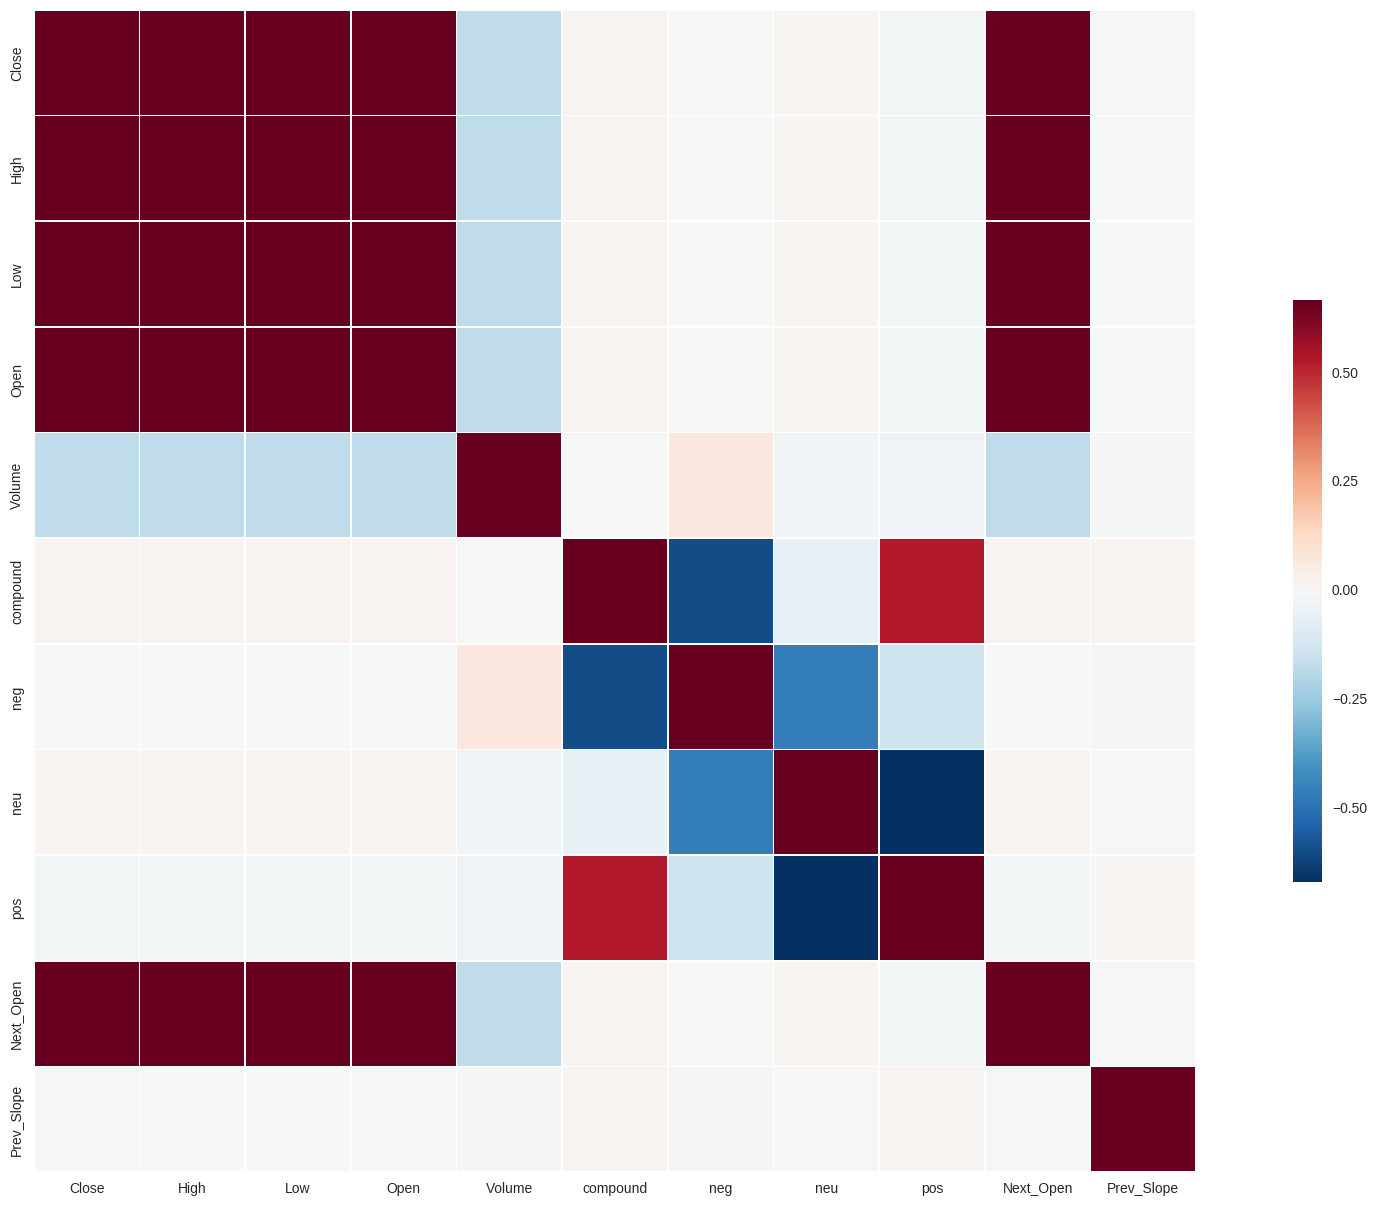

In [37]:
plt.figure(figsize=(25,15))
sns.heatmap(x.corr(), vmax=.3, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})

In [38]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3)

In [39]:
# params = {
#     'n_estimators': [10, 20, 50, 100, 200],
#     'max_depth': [None,1, 2, 3, 4, 5],
#     'min_samples_split': [2, 10, 25, 50, 100],
# #     'min_samples_leaf': [1, 2, 3, 4, 5, 10]
# }

# %time lr = evaluate_model(LinearRegression(n_jobs=-1), x_train, y_train, draw_features=False)
lr = evaluate_model(LinearRegression(n_jobs=-1), x_train, y_train, draw_features=False)

/home/ali/Anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


Mean score of the model is:        0.87547359013
Explained variance regression score:  0.945238273464
Mean Absolute Error:                  1.20124264459
Model socre is:                       1.0


In [46]:
lr_predictions = lr.predict(x_test)
lr.score(x_test, y_test)

0.91338024978822874

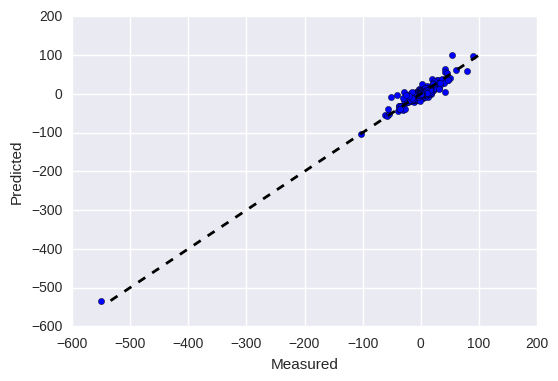

In [41]:
fig, ax = plt.subplots()
ax.scatter(y_test, lr_predictions)
ax.plot([lr_predictions.min(), lr_predictions.max()], [lr_predictions.min(), lr_predictions.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.figure(figsize=(1,1))
plt.show()

In [42]:
%time dt=evaluate_model(DecisionTreeRegressor(), x_train, y_train, draw_features=False)

Mean score of the model is:        0.431871968525
Explained variance regression score:  0.0859042476609
Mean Absolute Error:                  2.2110965187
Model socre is:                       1.0
CPU times: user 2.1 s, sys: 412 ms, total: 2.51 s
Wall time: 2.88 s


In [45]:
dt_predictions = dt.predict(x_test)
dt.score(x_test, y_test)

-0.043802595679051315

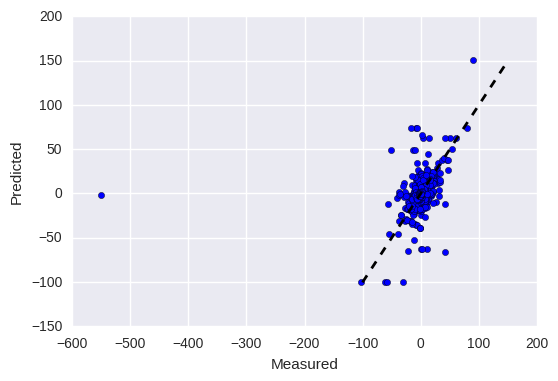

In [47]:
fig, ax = plt.subplots()
ax.scatter(y_test, dt_predictions)
ax.plot([dt_predictions.min(), dt_predictions.max()], [dt_predictions.min(), dt_predictions.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.figure(figsize=(1,1))
plt.show()

Mean score of the model is:        0.37011586548
Explained variance regression score:  0.793562246323
Mean Absolute Error:                  1.8100801532
Model socre is:                       1.0


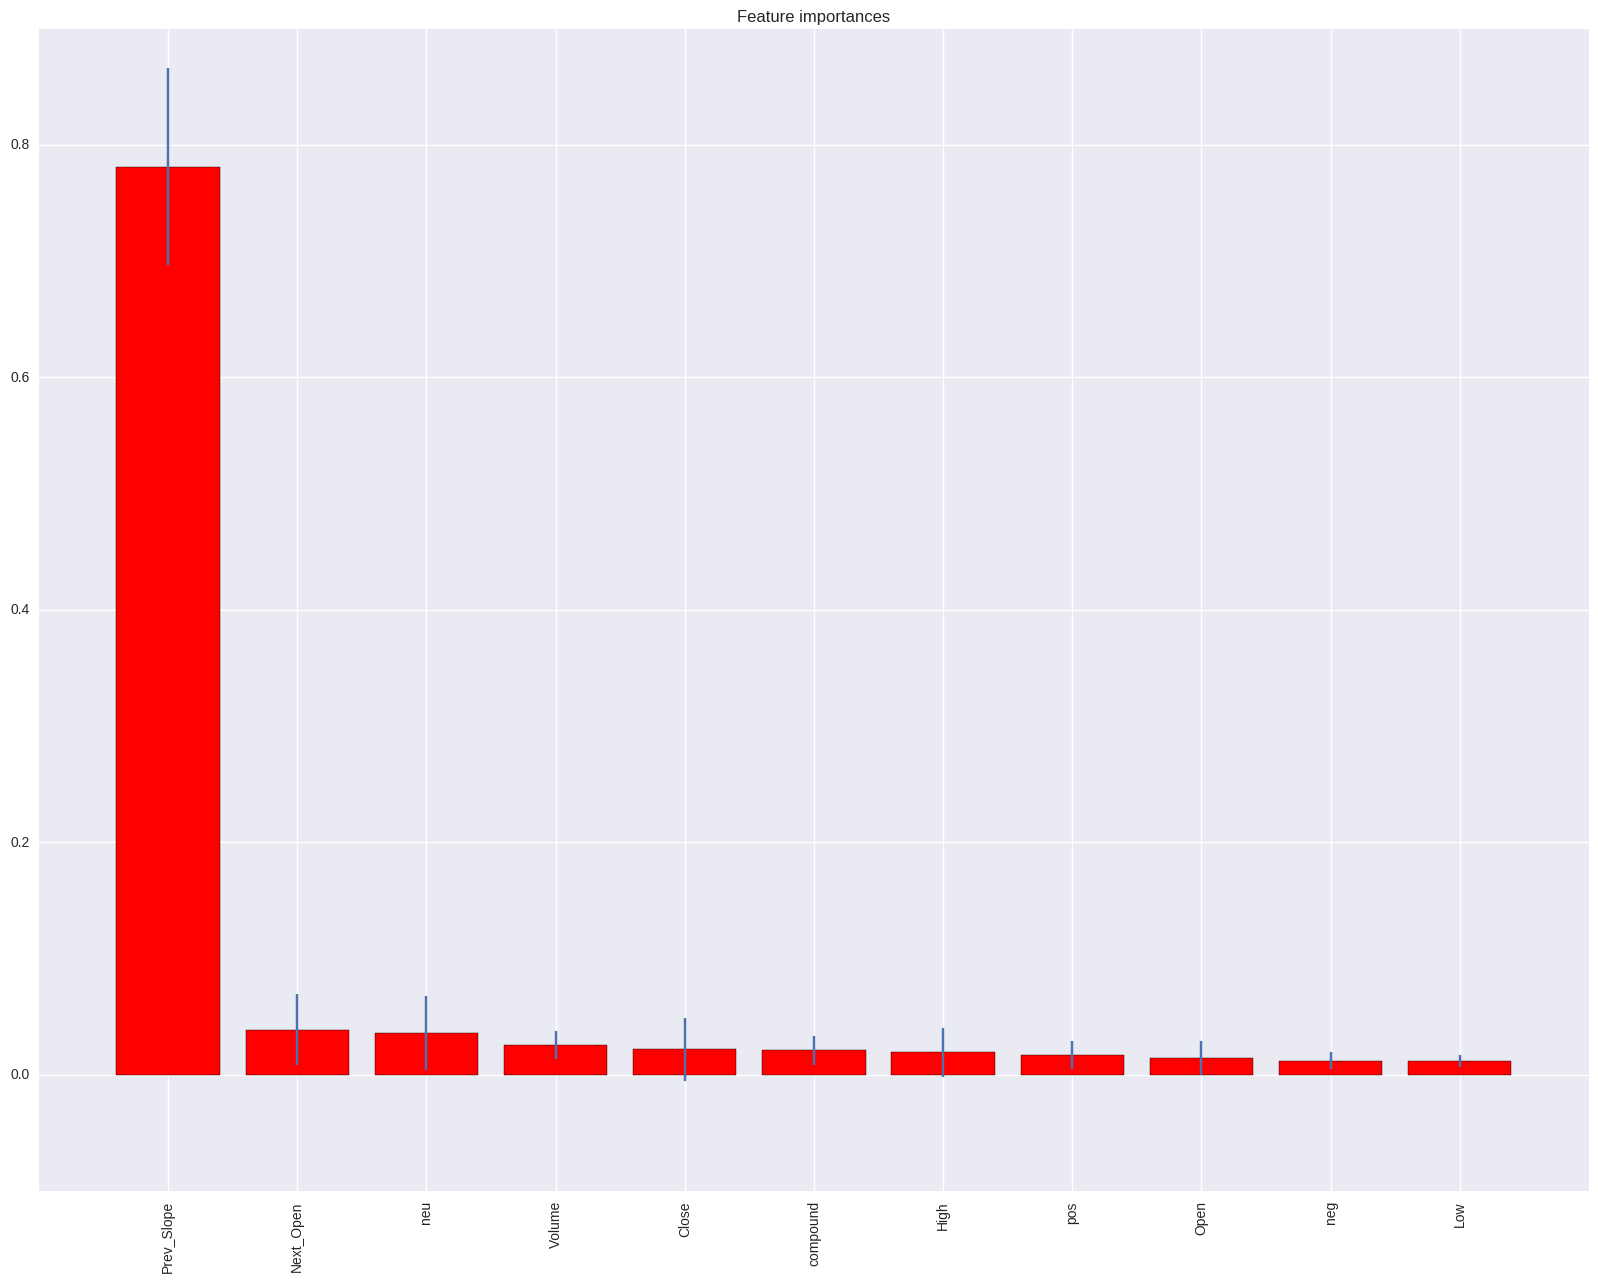

CPU times: user 4.93 s, sys: 540 ms, total: 5.47 s
Wall time: 5.15 s


In [48]:
%time rf=evaluate_model(RandomForestRegressor(n_jobs=-1), x_train, y_train)

In [50]:
rf_predictions = rf.predict(x_test)
rf.score(x_test, y_test)

0.13983545095622718

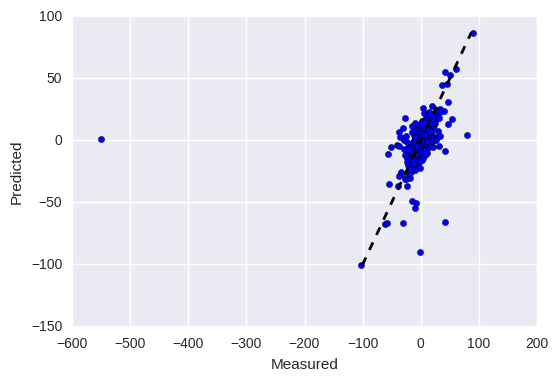

In [51]:
fig, ax = plt.subplots()
ax.scatter(y_test, rf_predictions)
ax.plot([rf_predictions.min(), rf_predictions.max()], [rf_predictions.min(), rf_predictions.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.figure(figsize=(20,15))
plt.show()

Mean score of the model is:        0.71345341099
Explained variance regression score:  0.435370252717
Mean Absolute Error:                  1.69699977465
Model socre is:                       1.0


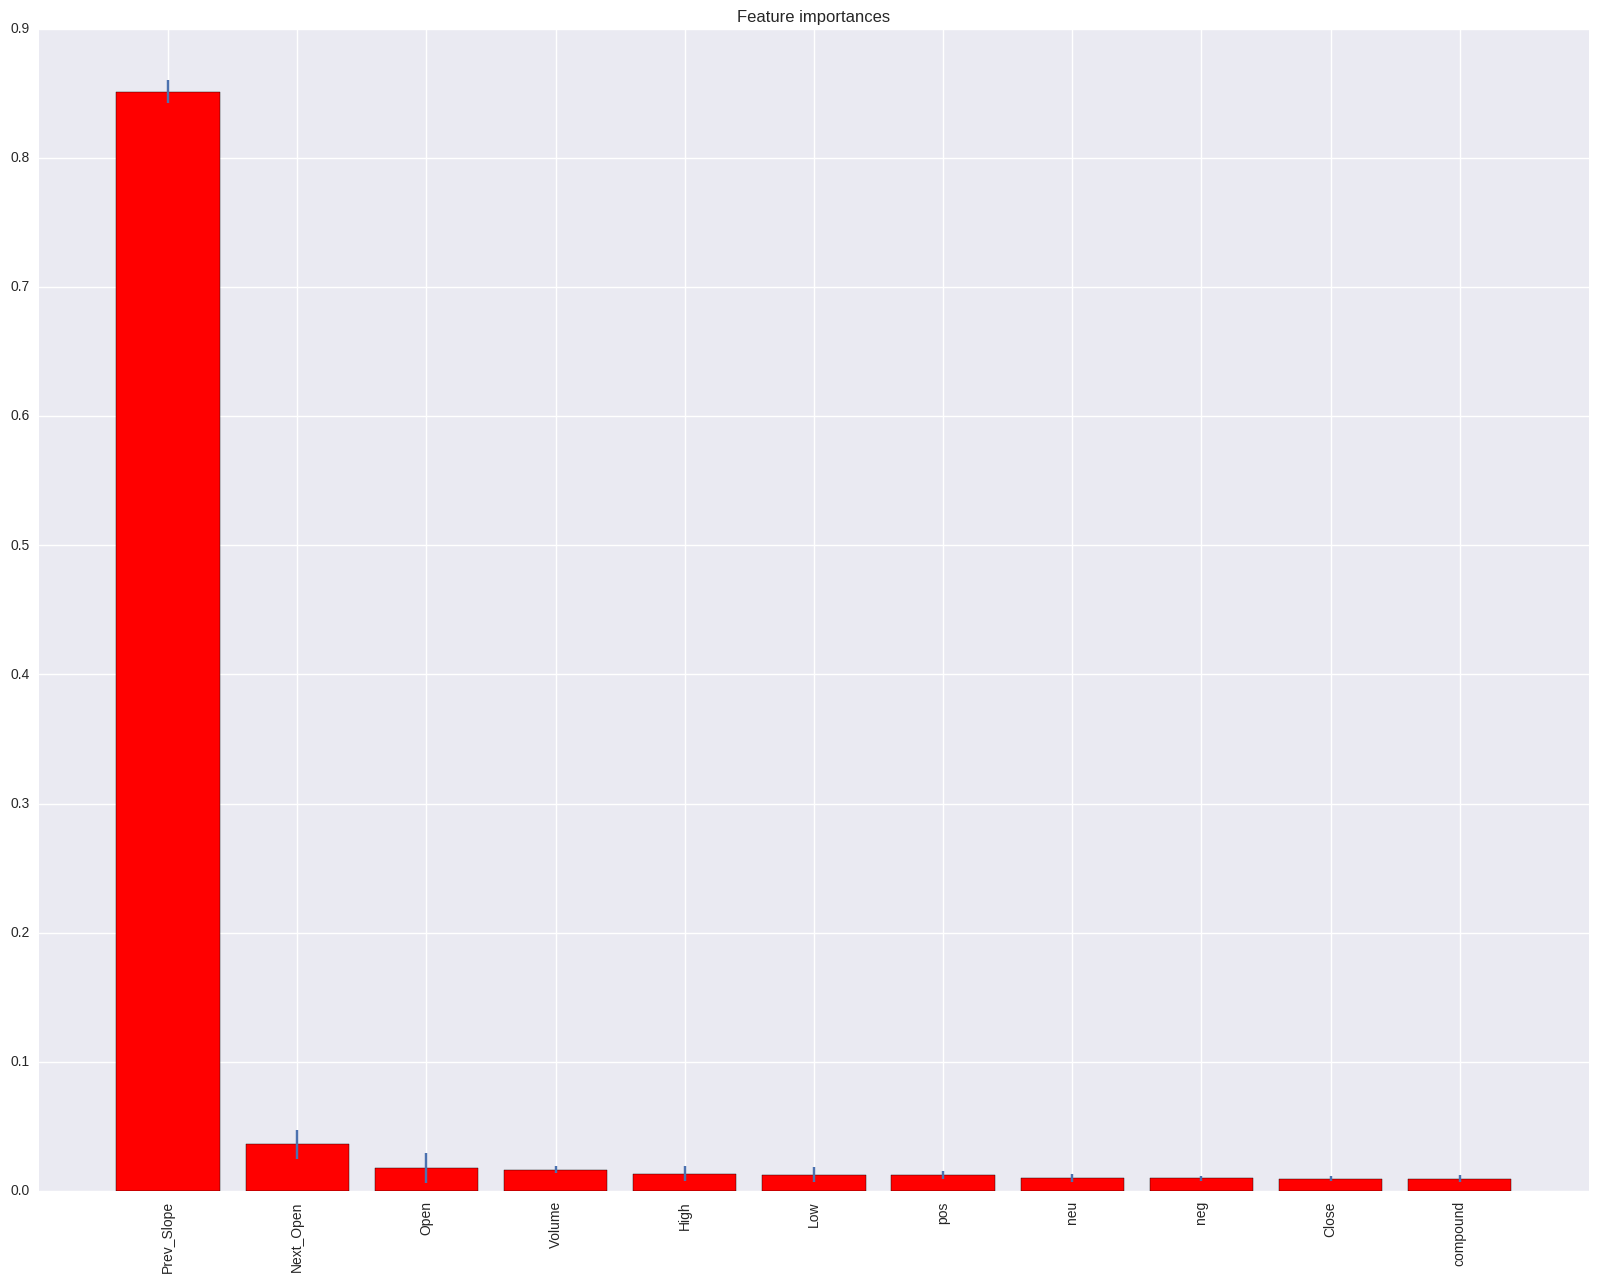

CPU times: user 3.3 s, sys: 612 ms, total: 3.91 s
Wall time: 4.5 s


In [52]:
%time et=evaluate_model(ExtraTreesRegressor(n_jobs=-1), x_train, y_train)

In [54]:
et_predictions = et.predict(x_test)
et.score(x_test, y_test)

0.14805524991329788

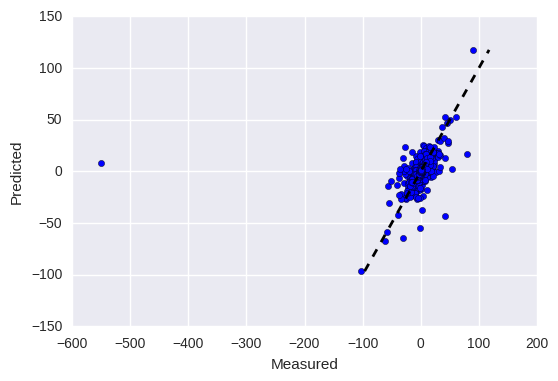

In [55]:
fig, ax = plt.subplots()
ax.scatter(y_test, et_predictions)
ax.plot([et_predictions.min(), et_predictions.max()], [et_predictions.min(), et_predictions.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.figure(figsize=(20,15))
plt.show()

Best Model after Grid Search:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Mean score of the model is:        0.571541511321
Explained variance regression score:  0.779378735753
Mean Absolute Error:                  1.91674728893
Model socre is:                       1.0


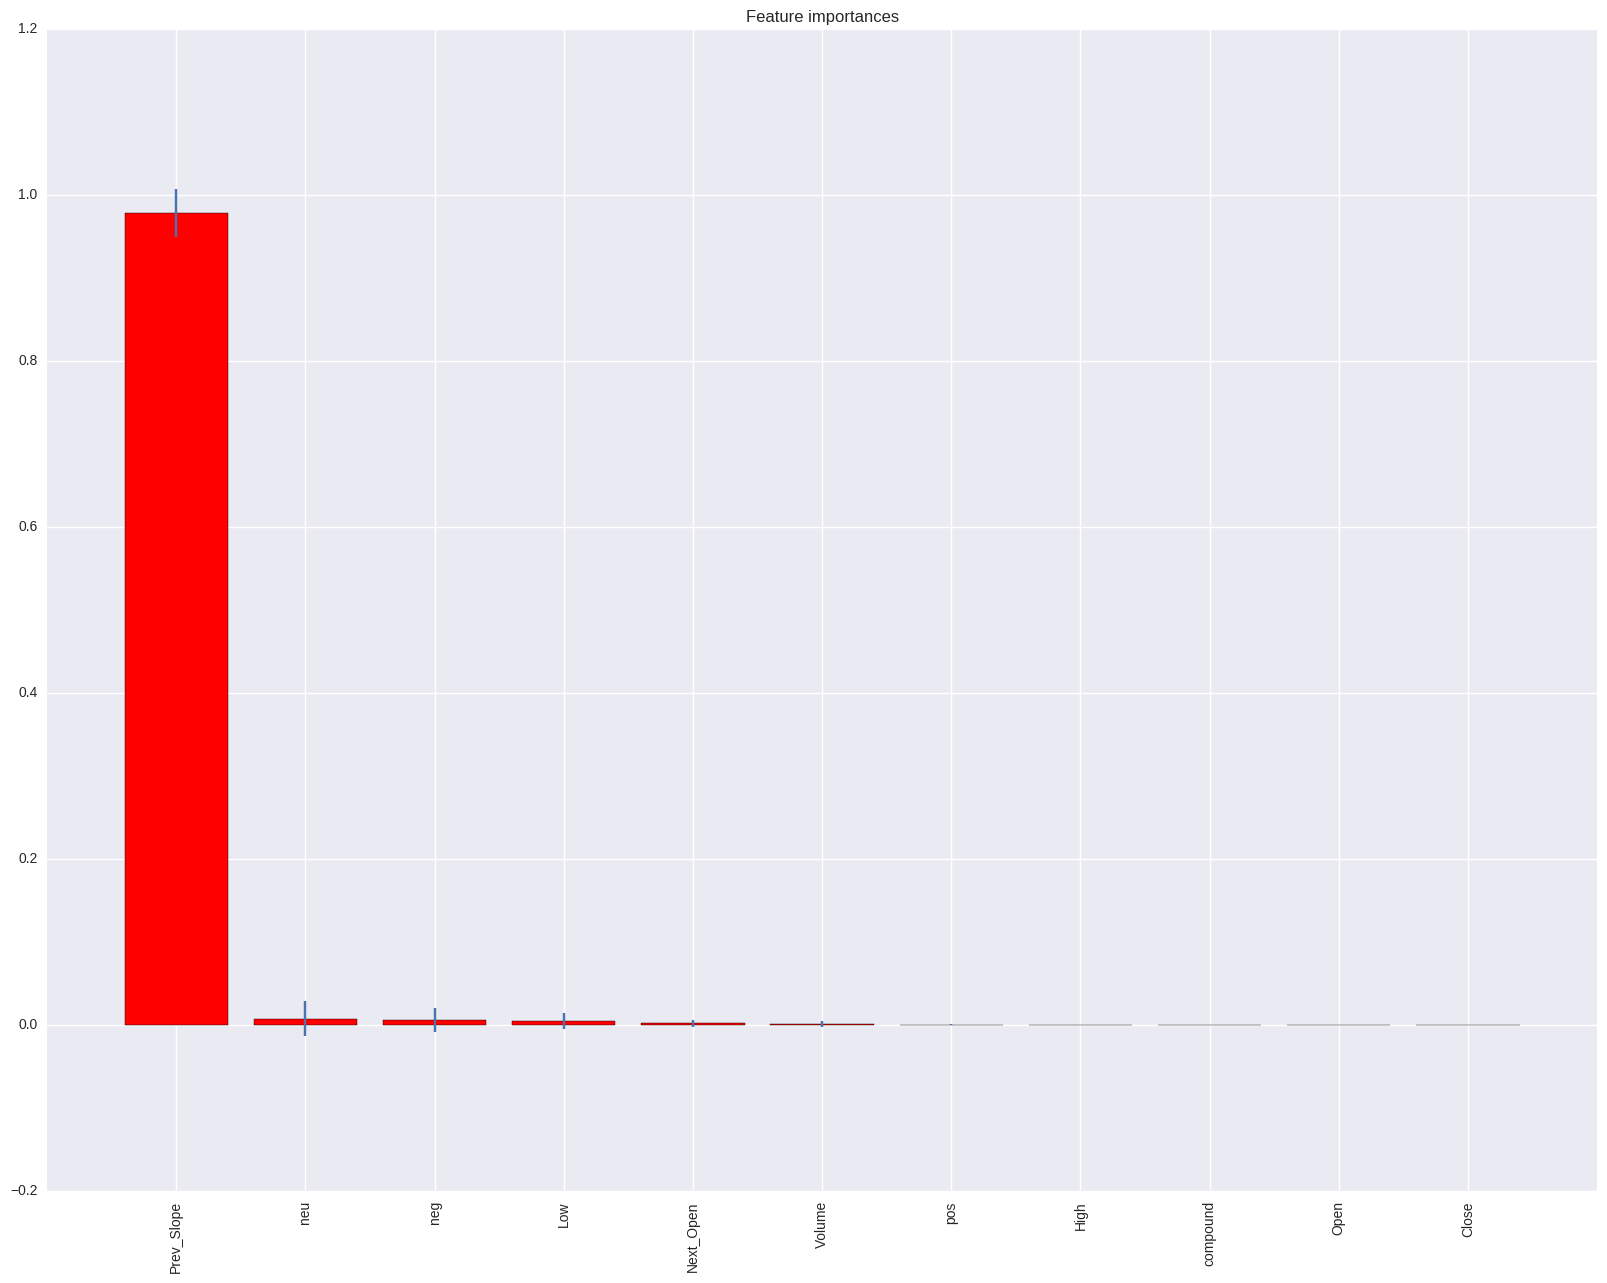

CPU times: user 23min 39s, sys: 16 s, total: 23min 56s
Wall time: 6min 48s


In [56]:
params = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': [None,1, 2, 3, 4, 5],
    'min_samples_split': [2, 10, 25, 50, 100],
#     'min_samples_leaf': [1, 2, 3, 4, 5, 10]
}
%time rf2=evaluate_model(RandomForestRegressor(n_jobs=-1), x_train, y_train, params=params)

In [58]:
rf2_predictions = rf2.predict(x_test)
rf2.score(x_test, y_test)

0.17107640818040548

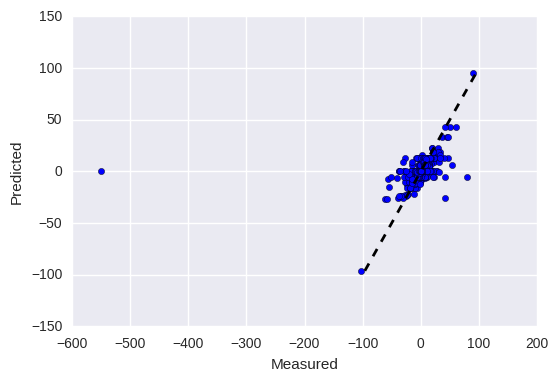

In [59]:
fig, ax = plt.subplots()
ax.scatter(y_test, rf2_predictions)
ax.plot([rf2_predictions.min(), rf2_predictions.max()], [rf2_predictions.min(), rf2_predictions.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.figure(figsize=(20,15))
plt.show()

Best Model after Grid Search:
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=25, min_weight_fraction_leaf=0.0,
          n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
Mean score of the model is:        0.736278612248
Explained variance regression score:  0.539709171873
Mean Absolute Error:                  1.65141516548
Model socre is:                       1.0


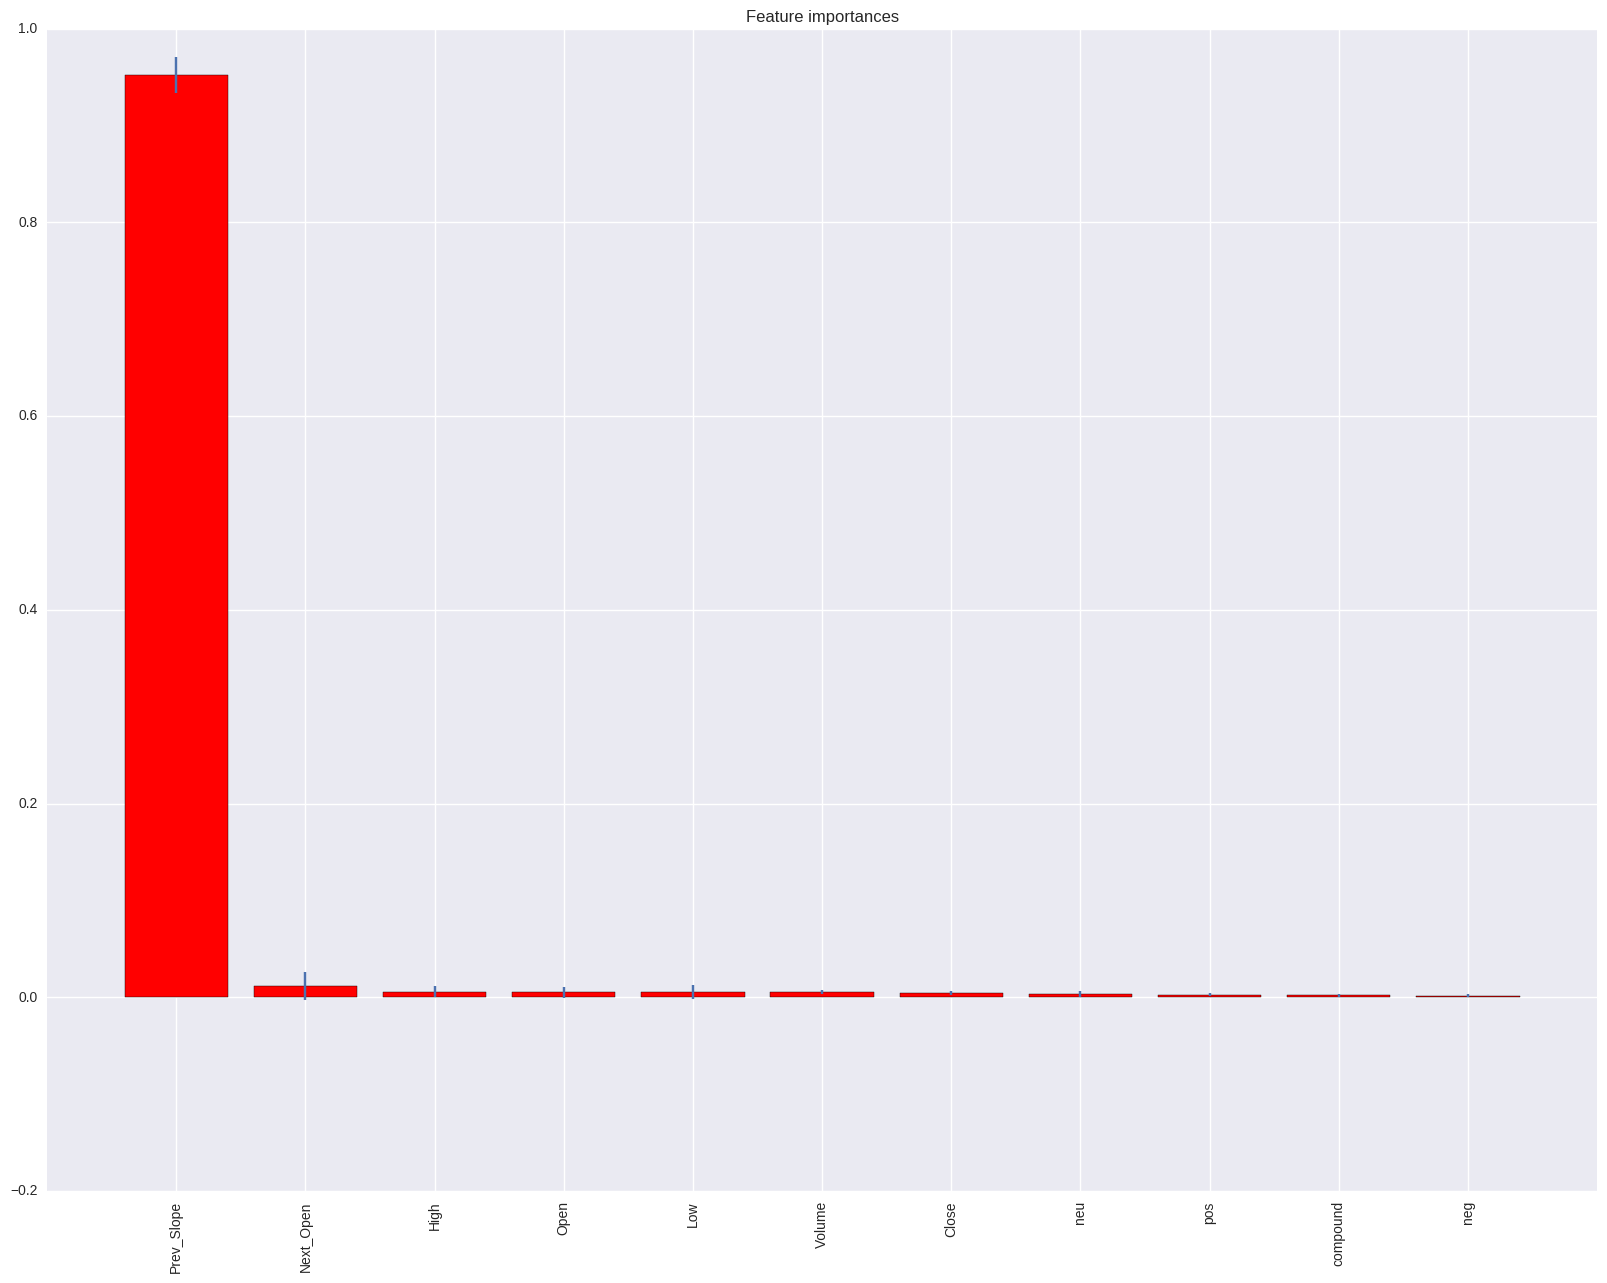

CPU times: user 6min 18s, sys: 17.8 s, total: 6min 36s
Wall time: 4min 39s


In [60]:
params = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': [None,1, 2, 3, 4, 5],
    'min_samples_split': [2, 10, 25, 50, 100],
}
%time et2=evaluate_model(ExtraTreesRegressor(n_jobs=-1), x_train, y_train, params=params)

In [61]:
et2_predictions = et2.predict(x_test)
et2.score(x_test, y_test)

0.18302697572165605

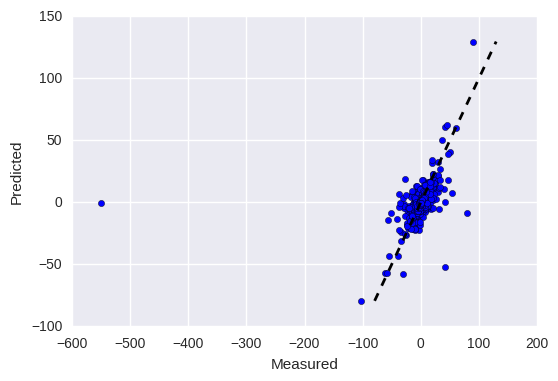

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, et2_predictions)
ax.plot([et2_predictions.min(), et2_predictions.max()], [et2_predictions.min(), et2_predictions.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.figure(figsize=(20,15))
plt.show()

In [ ]:
params = {
    'l1_ratio': [.1, .3, .5, .7, .9],
    'n_alphas': [100],
    'normalize': [True, False],
}
%time en=evaluate_model(ElasticNetCV(n_jobs=-1), x_train, y_train, params)

Best Model after Grid Search:
ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.9, max_iter=1000, n_alphas=100, n_jobs=-1,
       normalize=True, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)


In [ ]:
en_predictions = en.predict(x_test)
en.score(x_test, y_test)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, en_predictions)
ax.plot([en_predictions.min(), en_predictions.max()], [en_predictions.min(), en_predictions.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.figure(figsize=(20,15))
plt.show()

In [ ]:
# params = {
#     'n_estimators': [10, 20, 50, 100, 200],
#     'max_depth': [None,1, 2, 3, 4, 5],
#     'min_samples_split': [2, 10, 25, 50, 100],
# #     'min_samples_leaf': [1, 2, 3, 4, 5, 10]
# }
# start_time = time.time()
# rf=evaluate_model(RandomForestRegressor(n_jobs=-1), x_train, y_train, params)
# print 'This operation took '+ str(time.time() - start_time) + " seconds"